In [1]:
import os
import sys
from datetime import datetime
from os.path import abspath
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import matplotlib.pyplot as plt

yf.pdr_override()

from zipline.utils.run_algo import load_extensions
from zipline.data import bundles
from zipline.data.data_portal import DataPortal
from zipline.utils.calendar_utils import get_calendar

from zipline.api import set_max_leverage, schedule_function, set_benchmark,set_commission
from zipline.finance.commission import PerContract, PerDollar, PerShare, PerTrade
from zipline.finance.commission import CommissionModel
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage
from zipline.finance.commission import PerShare, PerTrade, PerDollar
from zipline.api import set_slippage, set_commission
from zipline.data.bundles import register, unregister, ingest
from zipline.data.bundles.csvdir import csvdir_equities
from zipline.utils.calendar_utils import register_calendar, get_calendar
from zipline.api import (order, 
                         order_target,
                         order_value,
                         record, 
                         symbol,
                         get_datetime,
                         order_target_percent,
                         order_target_value,
                         set_benchmark,
                         get_open_orders)
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.api import order_target, record, date_rules, time_rules, symbol # type: ignore


import quantstats as qs
import warnings
warnings.filterwarnings('ignore', category=Warning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

load_extensions(
    default=True,
    extensions=[],
    strict=True,
    environ=os.environ,
)
%matplotlib inline
%load_ext autoreload
%autoreload 2

ROOT_DIR = abspath('../')
sys.path.append(ROOT_DIR)

In [7]:
START_DATE = pd.Timestamp('2018-01-01')
END_DATE = pd.Timestamp('2023-01-01')

BASE_CAPITAL = 100_000

def calculate_years() -> int:
    return int((END_DATE - START_DATE).days / 365)

YEARS = calculate_years()

In [8]:
def plots(results):
    start = results.index[0]
    end = results.index[-1]
    benchmark = pdr.get_data_yahoo('^GSPC', start=start, end=end)['Adj Close'].pct_change()
    results.index = pd.to_datetime(results.index).tz_convert(None)
    results.index = benchmark.index  
    qs.reports.html(results['returns'], benchmark = benchmark, match_dates=True, figsize=(8, 4),
                    title = f"Bollinger Bnad Strategy ADF filter {YEARS} years",
                    output= f"{ROOT_DIR}/outputs/BBstrat_ADF_{YEARS}y.html")

In [9]:
parquet_file_path = f"{ROOT_DIR}/data/clusters/adf_cluster_{YEARS}y.parquet"
data = pd.read_parquet(parquet_file_path)
data = data.iloc[:, 0].tolist()

In [10]:
def rebalance_static(context, data):
    for stocks in context.portfolio.positions:
        current_price = data.current(stocks, 'price')
        cost_basis = context.portfolio.positions[stocks].cost_basis
        amount = context.portfolio.positions[stocks].amount

        if amount > 0:
            if current_price * (1 + context.take_profit) > cost_basis:
                order_target_percent(stocks, 0)
                context.profits += 1
            elif current_price * (1 - context.stop_loss) < cost_basis:
                order_target_percent(stocks, 0)
                context.stops += 1
        elif amount < 0:
            if  current_price * (1 - context.take_profit) < cost_basis:
                order_target_percent(stocks, 0)
                context.profits += 1
            elif current_price * (1 + context.stop_loss) > cost_basis:
                order_target_percent(stocks, 0)
                context.stops += 1

In [11]:
def initialize(context):
    context.idx = 0
    context.tickers = data
    context.bollinger_window = 20
    context.bollinger_dev = 1.5
    context.stop_loss, context.take_profit  = 0.05, 0.05
    context.stops, context.profits = 0, 0
    
    # set_commission(PerShare(cost=0.003))
    # set_slippage(VolumeShareSlippage(volume_limit=0.10, price_impact=0.15))

def handle_data(context, data):
    context.idx += 1
    if context.idx < context.bollinger_window:
        return

    for ticker in context.tickers:
        # Get historical price data using data.history
        prices = data.history(symbol(ticker), 'price', context.bollinger_window + 1, '1d')

        # Calculate Bollinger Bands
        sma = prices.mean()
        rolling_std = prices.std()
        upper_band = sma + (context.bollinger_dev * rolling_std)
        lower_band = sma - (context.bollinger_dev * rolling_std)

        current_price = data.current(symbol(ticker), 'price')
        # cost_basis = context.portfolio.positions[symbol(ticker)].cost_basis
        # amount = context.portfolio.positions[symbol(ticker)].amount
        
        # print(context)

        # Calculate stop-loss and take-profit levels
        stop_loss_price = current_price * (1 - context.stop_loss)
        take_profit_price = current_price * (1 + context.take_profit)

        # Generate signals based on Bollinger Bands, stop-loss, and take-profit
        if current_price > upper_band:
            order_target_percent(symbol(ticker), -0.2)  # Short position
        elif current_price < lower_band:
            order_target_percent(symbol(ticker), 0.2)  # Long position
        
        rebalance_static(context, data)
                
        # Record the values for later analysis
        record(
            price=current_price,
            mid=sma,
            upper=upper_band,
            lower=lower_band,
            stop_loss=stop_loss_price,
            take_profit=take_profit_price
        )
        
# Run the algorithm
results = run_algorithm(
    start=START_DATE,
    end=END_DATE,
    initialize=initialize,
    handle_data=handle_data,
    capital_base=BASE_CAPITAL,
    benchmark_returns=None,
    data_frequency='daily',
    bundle='sp500bundle',
)
plots(results)

[*********************100%%**********************]  1 of 1 completed


In [9]:
plots(results)

[*********************100%%**********************]  1 of 1 completed


In [14]:
print(results.columns)

Index(['period_open', 'period_close', 'ending_cash', 'shorts_count',
       'positions', 'longs_count', 'starting_cash', 'starting_value',
       'returns', 'transactions', 'capital_used', 'long_value', 'orders',
       'short_value', 'ending_value', 'long_exposure', 'pnl', 'short_exposure',
       'gross_leverage', 'portfolio_value', 'net_leverage', 'ending_exposure',
       'starting_exposure', 'sortino', 'algo_volatility', 'max_drawdown',
       'max_leverage', 'excess_return', 'treasury_period_return',
       'trading_days', 'period_label', 'algorithm_period_return',
       'benchmark_period_return', 'benchmark_volatility', 'alpha', 'beta',
       'sharpe', 'price', 'mid', 'upper', 'lower', 'stop_loss', 'take_profit'],
      dtype='object')


<bound method Series.unique of Date
2018-01-02     0.000000
2018-01-03     0.000000
2018-01-04     0.000000
2018-01-05     0.000000
2018-01-08     0.000000
                ...    
2022-12-23    11.716853
2022-12-27    11.125757
2022-12-28    12.013014
2022-12-29    11.580511
2022-12-30    11.950697
Name: gross_leverage, Length: 1259, dtype: float64>


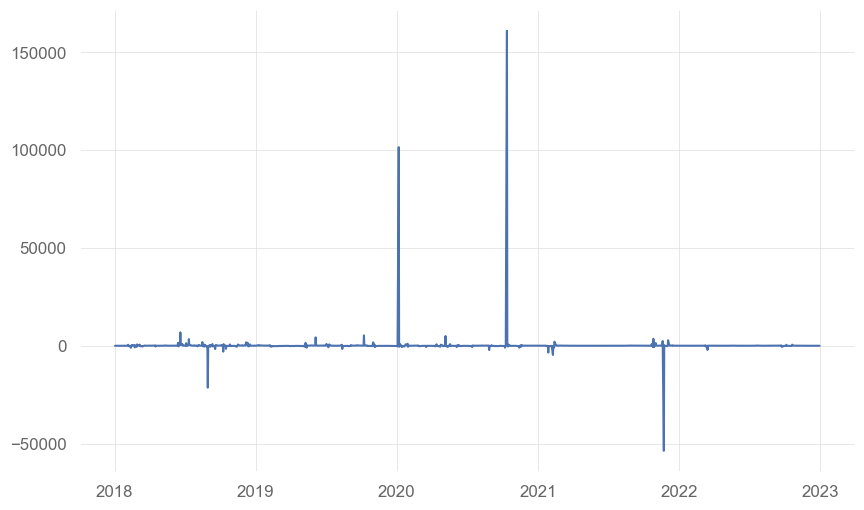

In [17]:
print(results["gross_leverage"].unique)
plt.plot(results["gross_leverage"])
# plt.plot(results["take_profit"])
# results.transactions.to_csv(f"{ROOT_DIR}/outputs/transactions.csv")

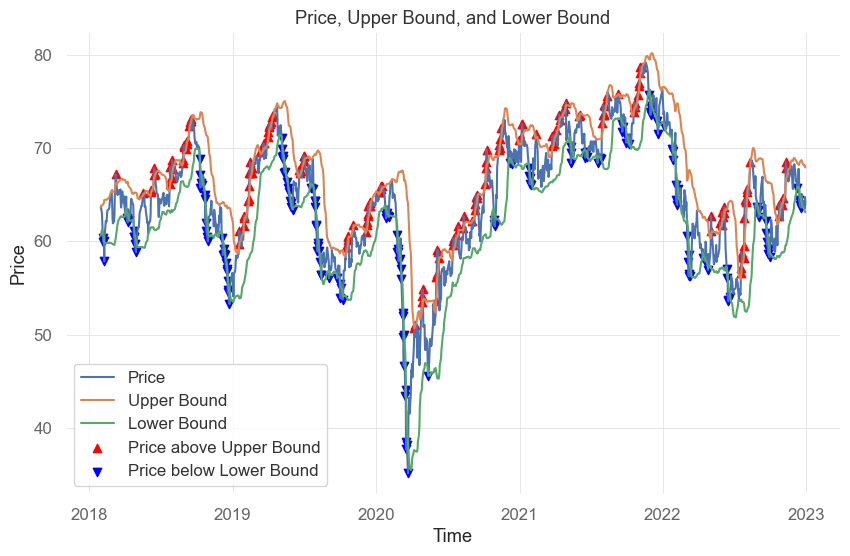

In [15]:
start = "2018-01-01"
end = "2023-01-01"
# Plot the price
plt.plot(results[start:end]["price"], label="Price")

# Plot the upper and lower bounds
plt.plot(results[start:end]["upper"], label="Upper Bound")
plt.plot(results[start:end]["lower"], label="Lower Bound")

# Identify the points where the price hits upper or lower bounds
upper_crossings = results[start:end][results["price"] > results["upper"]]
lower_crossings = results[start:end][results["price"] < results["lower"]]

# Highlight the points where the price hits upper bound
plt.scatter(upper_crossings.index, upper_crossings["price"], c='red', marker='^', label="Price above Upper Bound")

# Highlight the points where the price hits lower bound
plt.scatter(lower_crossings.index, lower_crossings["price"], c='blue', marker='v', label="Price below Lower Bound")

# Add legends
plt.legend()

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price, Upper Bound, and Lower Bound")

# Show the plot
plt.show()

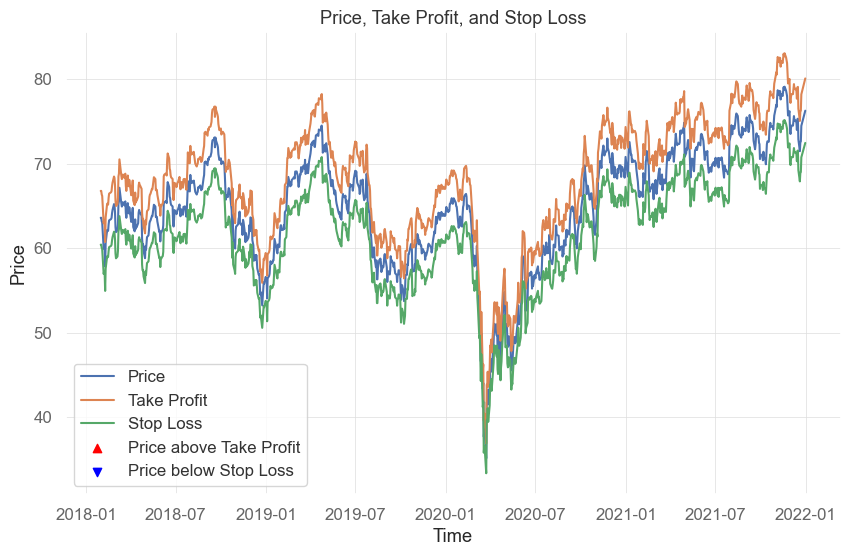

In [16]:
start = "2018-01-01"
end = "2022-01-01"

# Plot the price
plt.plot(results[start:end]["price"], label="Price")

# Plot the take_profit and stop_loss
plt.plot(results[start:end]["take_profit"], label="Take Profit")
plt.plot(results[start:end]["stop_loss"], label="Stop Loss")

# Identify the points where the price hits take_profit or stop_loss
take_profit_crossings = results[start:end][results["price"] > results["take_profit"]]
stop_loss_crossings = results[start:end][results["price"] < results["stop_loss"]]

# Highlight the points where the price hits take_profit
plt.scatter(take_profit_crossings.index, take_profit_crossings["price"], c='red', marker='^', label="Price above Take Profit")

# Highlight the points where the price hits stop_loss
plt.scatter(stop_loss_crossings.index, stop_loss_crossings["price"], c='blue', marker='v', label="Price below Stop Loss")

# Add legends
plt.legend()

# Add labels and title
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Price, Take Profit, and Stop Loss")

# Show the plot
plt.show()
